In [30]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# 1. 데이터 불러오기
df = pd.read_csv("C:/Users/LG/OneDrive/문서/GitHub/KBO_Prediction_ML/data/real_final.csv")  # 경로는 필요에 따라 수정하세요

In [31]:
# 1. 데이터 불러오기
df = pd.read_csv("../data/real_final.csv")

In [32]:
# 2. 결측치 확인
print(df.isnull().sum())

GameDate              0
home_Team             0
away_Team             0
Result                0
home_Recent_5_Win     0
home_Recent_5_Loss    0
home_OPS              0
home_BB               0
home_HBP              0
home_SO               0
home_ERA              0
home_BB_p             0
home_K                0
home_IR               0
home_IS               0
home_TBF              0
away_OPS              0
away_BB               0
away_HBP              0
away_SO               0
away_ERA              0
away_BB_p             0
away_K                0
away_IR               0
away_IS               0
away_TBF              0
dtype: int64


In [33]:
# 3. 문자열 타입(만약 있으면) 인코딩 (예: home_Team, away_Team가 숫자형이라면 생략 가능)
# LabelEncoder 적용. 
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [34]:
# 4. feature와 label 나누기
df = df.drop(columns=['GameDate'])
X = df.drop(columns=['Result'])
y = df['Result']

In [35]:
# 5. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

In [36]:
rf = RandomForestClassifier(random_state=3)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf_search = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy')
rf_search.fit(X_train, y_train)
print("Best RandomForest Params:", rf_search.best_params_)

Best RandomForest Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [37]:
rf_best_params = rf_search.best_params_

model = RandomForestClassifier(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    max_features=rf_best_params['max_features'],
    random_state=3
)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=3)

In [38]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Test AUC :", roc_auc_score(y_test, y_test_proba))

Accuracy: 0.8697068403908795
AUC: 0.9313806731259562
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       296
           1       0.88      0.87      0.87       318

    accuracy                           0.87       614
   macro avg       0.87      0.87      0.87       614
weighted avg       0.87      0.87      0.87       614

[[258  38]
 [ 42 276]]
Train Accuracy: 0.9991850040749797
Test Accuracy : 0.8697068403908795
Train AUC: 0.9999986697740745
Test AUC : 0.9313806731259562


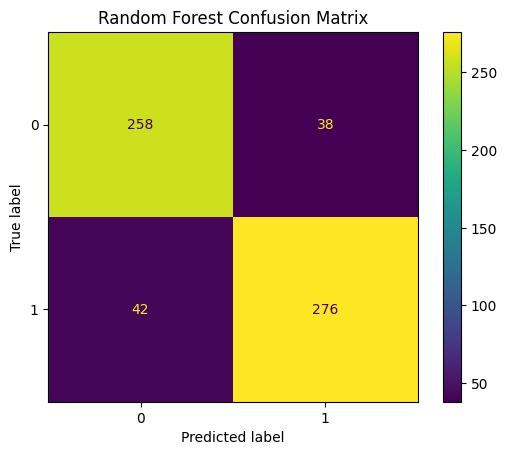

In [39]:
# 9. Confusion Matrix 시각화
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

plt.title("Random Forest Confusion Matrix")
plt.show()

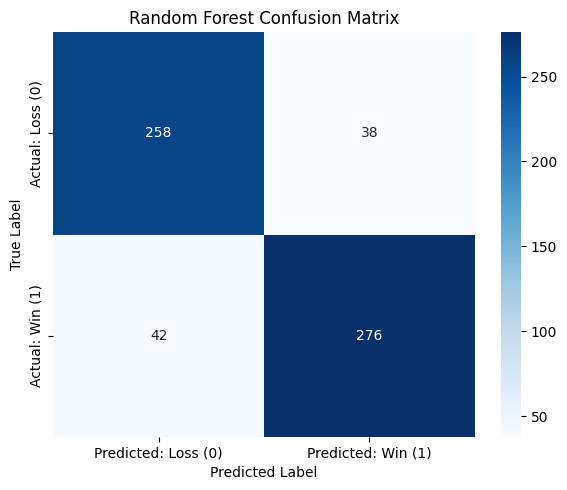

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix 값 수동 설정 (Random Forest 결과)
cm = [[258, 38],
      [42, 276]]

# Confusion matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: Loss (0)', 'Predicted: Win (1)'],
            yticklabels=['Actual: Loss (0)', 'Actual: Win (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()


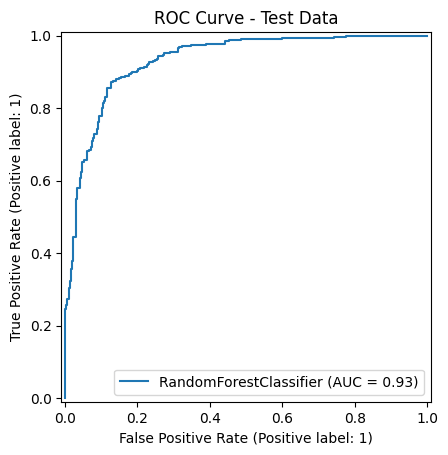

In [42]:
# 10. ROC Curve 시각화
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve - Test Data")
plt.show()

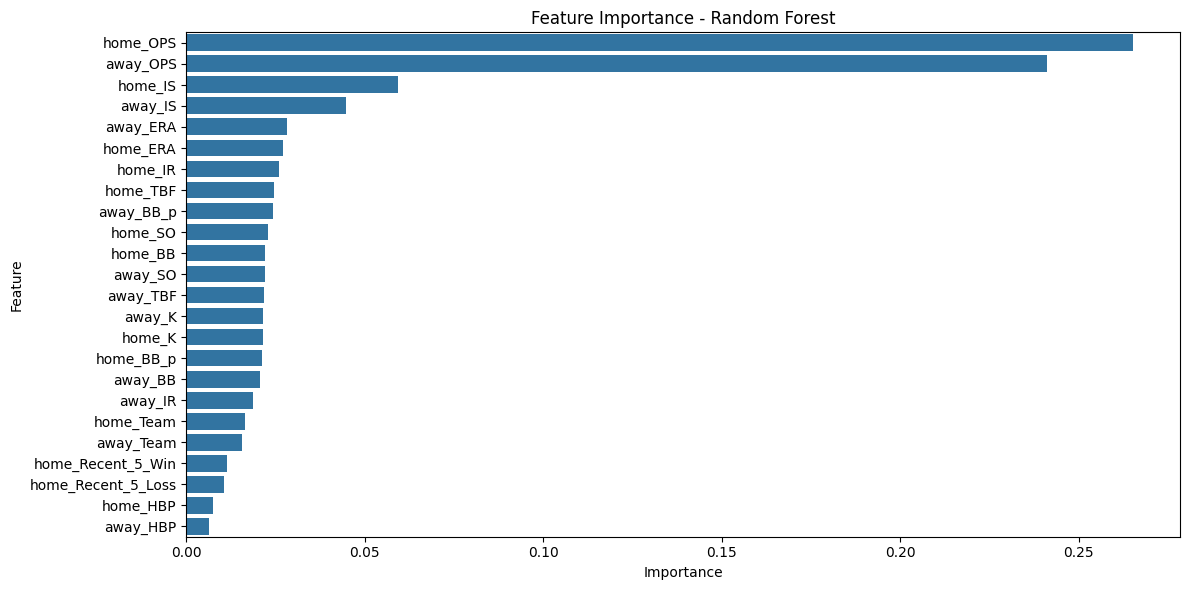

In [43]:
# 11. Feature Importance 시각화
importances = model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [44]:
# 12. 모델 저장
joblib.dump(model, 'best_random_forest_model_manual.pkl')
print("모델이 'best_random_forest_model_manual.pkl' 파일로 저장되었습니다.")

모델이 'best_random_forest_model_manual.pkl' 파일로 저장되었습니다.


In [45]:
X_train.to_csv('../models/X_train_rf.csv', index=False)